In this experiment, using Split Conformal Prediction, we want to analyze the following:

1.   How different can be $\mathcal{D}_{\text{train}}$ and $\mathcal{D}_{\text{calib}}$?
2.   How much variation can $\mathcal{D}_{\text{calib}}$ take? Add Gaussian noise to assess it.

1.   What partitions of a finite set works?
2.   Evaluate Coverage and Prediction Set Size.

1.   APS vs SCP is implemented as recalibrating/or not in the last loop.


# Libraries & Data

In [ ]:
!pip install timm torchvision matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
#from tensorflow.keras.datasets import mnist
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.nn.functional import softmax
from torch.utils.data import random_split
import torch.nn as nn
from tqdm import tqdm
import math

In [ ]:
#Alternative as MNIST original link keeps failing...
transform = transforms.Compose([transforms.ToTensor()])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X = mnist.data.numpy().reshape(-1, 784) / 255.0
y = mnist.targets.numpy()

y = y.astype(int)

len(X)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 535kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 13.7MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



60000

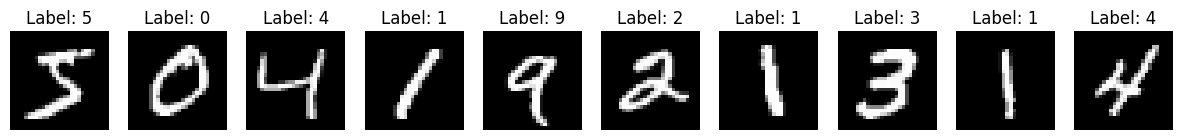

In [ ]:
# Display of the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {y[i]}")
plt.show()

# Model Fitting with $\mathcal{D}_{\text{train}}$



### MLP

In [ ]:
# Splitting dataset randomly into Training (D_Train) and Calibration (D_Calib)
# 70% for training, 30% for calibration
X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Model is a simple MLP classifier (Multilayer Perceptron)
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=20, random_state=42)
clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=20, random_state=42)

In [ ]:
# Function to calculate accuracy
def compute_accuracy(X, y, model):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred)

original_accuracy = compute_accuracy(X_calib, y_calib, clf)
print(f"Original accuracy on calibration set: {original_accuracy}")

Original accuracy on calibration set: 0.9727222222222223


### Resnet & Inception (Pretrained, timm)

In [ ]:
%%script false --no-raise-error

def setup_model(model_name):
    model = timm.create_model(model_name, pretrained=True)  # Check number of classes

    # Obtener el número de características de entrada para la capa final (dependiendo del modelo)
    in_features = model.fc.in_features if hasattr(model, 'fc') else model.head.fc.in_features

    # Modificar la capa final para que tenga 10 salidas (para 10 clases)
    if hasattr(model, 'fc'):
        model.fc = nn.Linear(in_features, 10)  # Ajuste para ResNet, Inception y otros modelos similares
    elif hasattr(model, 'head'):
        model.head.fc = nn.Linear(in_features, 10)  # Ajuste para modelos como EfficientNet
    else:
        raise ValueError("Unsupported model architecture")

    model.eval()
    return model

In [ ]:
def setup_model(model_name):
    model = timm.create_model(model_name, pretrained=True,num_classes=10)  # Simplyfied
    model.eval()
    return model

In [ ]:
# Loading here the trained models by Protim
def setup_model(model_name, checkpoint_path=None):
    model = timm.create_model(model_name, pretrained=False ,num_classes=10)  # Simplyfied

    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint)
        print(f"Checkpoint loaded: {checkpoint_path}")

    model.eval()
    return model

In [ ]:
def setup_model(model_name, checkpoint_path=None):
    model = timm.create_model(model_name, pretrained=False, num_classes=10)

    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint

        new_state_dict = {}
        for key in state_dict:
            new_key = key.replace('model.', '')
            new_state_dict[new_key] = state_dict[key]

        model.load_state_dict(new_state_dict)
        print(f"Checkpoint loaded: {checkpoint_path}")

    model.eval()
    return model

In [ ]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Replicate the single channel
    ])

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize

def get_transforms():
    return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.34433492, 0.38015251, 0.40769764), (0.20382567, 0.13680683, 0.11487552)),
            transforms.Resize((224,224)),
            transforms.ConvertImageDtype(torch.float32),
            ])

In [ ]:
from torchvision.datasets import EuroSAT
from torch.utils.data import random_split, Subset

### A first test to split the data and check the models... ###
transform = get_transforms()
full_dataset = datasets.EuroSAT(root='./data', download=True, transform=transform)
#full_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#MNIST(root='./data', train=False, download=True, transform=transform)

indices = torch.randperm(len(full_dataset)).tolist()
subset_size = int(0.02 * len(full_dataset))
subset_indices = indices[:subset_size]

# Get subsample
subset = Subset(full_dataset, subset_indices)
#############################################

calib_percentage = 0.5  # 50% for Calibration

# Subset sizes
calib_size = math.floor(calib_percentage * len(subset))
test_size = len(subset) - calib_size

# Data splitting: calibration and test
calib_dataset, test_dataset = random_split(subset, [calib_size, test_size])

# DataLoaders
calib_dataloader = DataLoader(calib_dataset, batch_size=25) #100, probably should be smaller...
test_dataloader  = DataLoader(test_dataset, batch_size=25)

subset_labels = {full_dataset.targets[i] for i in subset_indices}
print(subset_labels)

100%|██████████| 94.3M/94.3M [00:00<00:00, 121MB/s]


Extracting ./data/eurosat/EuroSAT.zip to ./data/eurosat
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


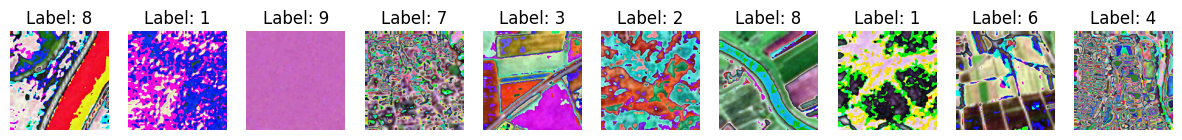

In [ ]:
def show_images(dataloader, num_images=10):
    images, labels = next(iter(dataloader))  # Get the first batch of images and labels
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        img = images[i]
        img = F.to_pil_image(img)  # Convert to PIL image

        axes[i].imshow(img, cmap="gray")  # Ensure grayscale display
        axes[i].axis("off")
        axes[i].set_title(f"Label: {labels[i].item()}")

    plt.show()

show_images(test_dataloader, num_images=10)

In [ ]:
# Around 4 mins

def get_predictions(model, dataloader):
    predictions = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc="Progress", unit="batch"):
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            predictions.append(probs.numpy())
    return np.concatenate(predictions)

# Testing models outputs
inception_v3_model = setup_model('inception_v3', '/content/drive/MyDrive/protim_checkpoints/inceptionv3_Checkpoint epoch=29-train_acc=1.00-train_loss=0.000-val_acc=0.98.ckpt')
inception_preds = get_predictions(inception_v3_model, test_dataloader)
print("Inception predictions shape:", inception_preds.shape)

resnet50_model = setup_model('resnet50', '/content/drive/MyDrive/protim_checkpoints/resnet_50_Checkpoint epoch=119-train_acc=0.94-train_loss=0.028-val_acc=0.95.ckpt')
resnet_preds = get_predictions(resnet50_model, test_dataloader)
print("ResNet predictions shape:", resnet_preds.shape)

<ipython-input-11-a601cc4bd917>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


Checkpoint loaded: /content/drive/MyDrive/protim_checkpoints/inceptionv3_Checkpoint epoch=29-train_acc=1.00-train_loss=0.000-val_acc=0.98.ckpt


Progress: 100%|██████████| 11/11 [00:31<00:00,  2.83s/batch]


Inception predictions shape: (270, 10)
Checkpoint loaded: /content/drive/MyDrive/protim_checkpoints/resnet_50_Checkpoint epoch=119-train_acc=0.94-train_loss=0.028-val_acc=0.95.ckpt


Progress: 100%|██████████| 11/11 [00:45<00:00,  4.10s/batch]

ResNet predictions shape: (270, 10)


In [ ]:
def compute_model_accuracy(predictions, true_labels):
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy

# Extrating labels for each image
true_labels = np.array([target for _, target in test_dataset])

inception_accuracy = compute_model_accuracy(inception_preds, true_labels)
print(f"Inception Accuracy: {inception_accuracy}")

resnet_accuracy = compute_model_accuracy(resnet_preds, true_labels)
print(f"ResNet Accuracy: {resnet_accuracy}")

Inception Accuracy: 0.9925925925925926
ResNet Accuracy: 0.9592592592592593


In [ ]:
images, labels = next(iter(test_dataloader))
print("Shape of images:", images.shape)
print("Labels:", labels)

Shape of images: torch.Size([25, 3, 224, 224])
Labels: tensor([8, 1, 9, 7, 3, 2, 8, 1, 6, 4, 7, 7, 0, 9, 6, 5, 3, 1, 2, 0, 4, 8, 7, 3,
        7])


In [ ]:
unique_labels = np.unique(np.array([target for _, target in calib_dataset]))
unique_labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
inception_preds.shape

(270, 10)

In [ ]:
## CHECK ACCURACY OF TIMM MODELS

# Split Conformal Prediction with $\mathcal{D}_{\text{calib}}$

In [ ]:
# Getting the predicted probabilities for the calibration set
# Testing with MLP
prob_calib = clf.predict_proba(X_calib)

prob_calib_rounded = np.round(prob_calib[:5], 2)

df_calib_example = pd.DataFrame({
    "Sample": np.arange(5),
    "True Label (y_calib)": y_calib[:5],
    "Predicted Probabilities (prob_calib)": [probs.tolist() for probs in prob_calib_rounded[:5]]})

df_calib_example.reset_index(drop=True, inplace=True)

# Functions: nonconformity_score, add_gaussian_noise, conformal_prediction_interval

In [ ]:
# Evaluating the model on the Calibration set (D_Calib) using the model's confidence
# Conformal prediction uses "nonconformity scores" to check how unusual a prediction is.
# Here we use the softmax output for a more confident prediction.

alpha_value = 0.1

# Function to compute nonconformity score (based on class probabilities)
def nonconformity_score(y_true, y_pred_proba):
    return 1 -y_pred_proba[np.arange(len(y_true)), y_true]

calib_scores = nonconformity_score(y_calib, prob_calib)

In [ ]:
# Add Gaussian noise to the Calibration set and evaluate prediction intervals
# This will change the distribution of the calibration data

def add_gaussian_noise(X, mean=0, std=0.1):
    return X + np.random.normal(loc=mean, scale=std, size=X.shape)

In [ ]:
 # Calculating prediction intervals based on the nonconformity scores
# Defining a function to calculate conformal prediction intervals

def conformal_prediction_interval(nonconformity_scores, alpha=alpha_value):

    threshold = np.quantile(nonconformity_scores, 1 - alpha, method='higher') # Compute the (1-alpha) quantile of the nonconformity scores
    return threshold

# Calculate prediction intervals for both original and noisy calibration sets
#threshold_calib = conformal_prediction_interval(calib_scores, alpha=alpha_value)
#threshold_calib_noisy = conformal_prediction_interval(calib_scores_noisy, alpha=alpha_value)

#print("Prediction interval for original calibration set:", threshold_calib)
#print("Prediction interval for noisy calibration set:", threshold_calib_noisy)

In [ ]:
# Calculating prediction sets
def prediction_set(y_pred_proba, threshold, num_classes=10):
    # A prediction set includes all classes where the nonconformity score is less than the threshold
    return [i for i in range(num_classes) if 1-y_pred_proba[0, i] <= threshold]

#Prediction sets for both original and noisy calibration sets
#pred_set_calib       = [prediction_set(prob_calib[i:i+1], threshold_calib) for i in range(len(y_calib))]
#pred_set_calib_noisy = [prediction_set(prob_calib_noisy[i:i+1], threshold_calib_noisy) for i in range(len(y_calib))]

# How does Coverage change with noise?

### SPC - no recalibration

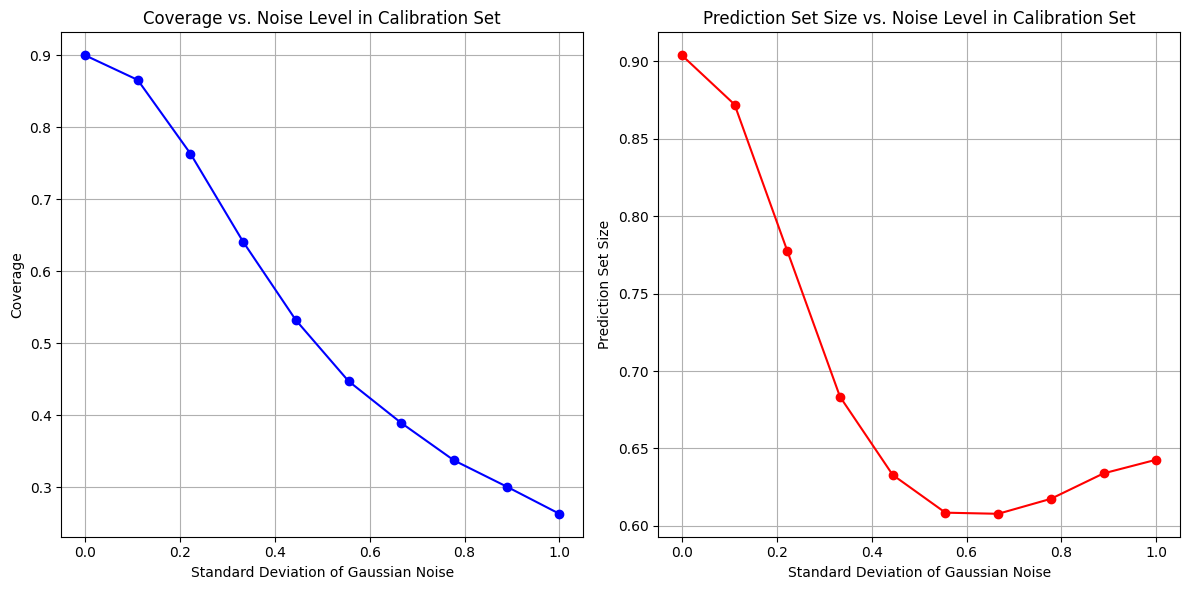

In [ ]:
# Function to calculate coverage for a set of predictions
def calculate_coverage(nonconformity_scores, threshold):
    # Coverage is the proportion of nonconformity scores <= threshold
    return np.mean(nonconformity_scores <= threshold)

# Set size function is already defined...

# Generate noisy calibration sets with increasing Gaussian noise
noise_levels = np.linspace(0, 1, 10)  # From no noise to high noise
coverages = []
set_sizes = []

# Compute the coverage and set size for each noise level
for noise_level in noise_levels:
    # Add Gaussian noise to the calibration set
    X_calib_noisy = add_gaussian_noise(X_calib, mean=0, std=noise_level)
    prob_calib_noisy = clf.predict_proba(X_calib_noisy)

    # Compute nonconformity scores for the noisy calibration set
    calib_scores_noisy = nonconformity_score(y_calib, prob_calib_noisy)

    # Calculate the threshold (with/out noise)
    threshold_calib = conformal_prediction_interval(calib_scores, alpha=alpha_value)
    threshold_calib_noisy = threshold_calib #conformal_prediction_interval(calib_scores_noisy, alpha=alpha_value)

    # Calculate coverage for noisy calibration set
    coverage = calculate_coverage(calib_scores_noisy, threshold_calib_noisy) #threshold_calib_noisy
    coverages.append(coverage)

    # Calculate the set size for noisy calibration set
    pred_set_calib_noisy = [prediction_set(prob_calib_noisy[i:i+1], threshold_calib_noisy) for i in range(len(y_calib))] # Shouldnt it be threshold_calib_noisy?
    size_pred_set_calib_noisy = [len(pred_set) for pred_set in pred_set_calib_noisy]
    set_sizes.append(np.mean(size_pred_set_calib_noisy))

# Plot the coverage vs. noise level
plt.figure(figsize=(12, 6))

# Plot coverage
plt.subplot(1, 2, 1)
plt.plot(noise_levels, coverages, marker='o', color='b')
plt.xlabel('Standard Deviation of Gaussian Noise')
plt.ylabel('Coverage')
plt.title('Coverage vs. Noise Level in Calibration Set')
plt.grid(True)

# Plot set size (the sizes of the prediction sets)
plt.subplot(1, 2, 2)
plt.plot(noise_levels, set_sizes, marker='o', color='r')
plt.xlabel('Standard Deviation of Gaussian Noise')
plt.ylabel('Prediction Set Size')
plt.title('Prediction Set Size vs. Noise Level in Calibration Set')
plt.grid(True)

plt.tight_layout()
plt.show()

The purpose of this is to check with the original calibration (no noise), how much can we distort new data (which is the calibration + noise) to see how much can $D_{\text{train}}$ and $D_{\text{calib}}$ be???

What about set size behavoir?

I think it is fixed once the threshold is computed, at least to a max value. For varying prediction set sizes, one has probably to resort to APS or RAPS (as in MAPIE/Protim code for paper)


### APS for timm models (Resnet50 and Inception_v3)

In [ ]:
def create_noisy_dataloader(subset, batch_size=25, noise_std=0.1):
    original_loader = DataLoader(subset, batch_size=batch_size)

    def add_noise(loader):
        for images, labels in loader:
            noise = torch.randn_like(images) * noise_std
            yield images + noise, labels

    return add_noise(original_loader)

In [ ]:
def get_noisy_predictions(model, subset, noise_std=0.1, split_ratio=0.7, batch_size=25):
    loader = create_noisy_dataloader(subset, batch_size)
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            noise = torch.randn_like(images) * noise_std
            outputs = model(images + noise)
            all_outputs.append(torch.softmax(outputs, dim=1))
            all_labels.append(labels)

    if not all_outputs:  # Check if list is empty
        raise ValueError("No predictions were generated")

    probs = torch.cat(all_outputs)
    labels = torch.cat(all_labels)

    n = int(split_ratio * len(labels))
    idx = np.array([1] * n + [0] * (len(labels) - n)) > 0
    np.random.shuffle(idx)

    return probs[idx], probs[~idx], labels[idx], labels[~idx], n

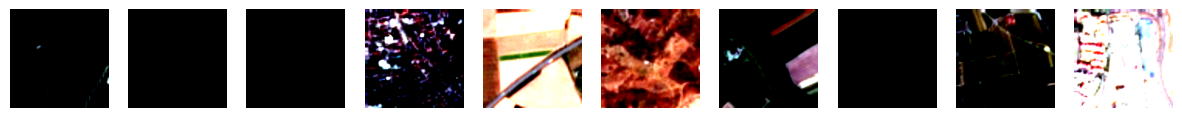

In [ ]:
noise = torch.randn_like(images) * 0 #0.5, 1
images_noisy = images + noise
images_noisy = torch.clamp(images_noisy, 0, 1)

fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    img = images_noisy[i]
    img = F.to_pil_image(img.squeeze())  # Add squeeze() to remove singleton dimensions
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
plt.show()

In [ ]:
subset20 = torch.utils.data.Subset(subset, indices=range(80))
subset20

In [ ]:
### TEST with timm models ###
alpha_value = 0.1
noise_levels = np.linspace(0, 1, 3)  # From no noise to high noise

# Models to evaluate
model_names = ['inception_v3', 'resnet50']
ckpt_paths = {'inception_v3': '/content/drive/MyDrive/protim_checkpoints/inceptionv3_Checkpoint epoch=29-train_acc=1.00-train_loss=0.000-val_acc=0.98.ckpt',
              'resnet50': '/content/drive/MyDrive/protim_checkpoints/resnet_50_Checkpoint epoch=119-train_acc=0.94-train_loss=0.028-val_acc=0.95.ckpt'}


# Dictionaries to store results for each model
model_coverages = {name: [] for name in model_names}
model_set_sizes = {name: [] for name in model_names}

i = 1

for model_name in model_names:

    ckpt_path = ckpt_paths.get(model_name, None)

    if ckpt_path:
        model = setup_model(model_name, ckpt_path)
    else:
        print(f"No checkpoint found for {model_name}. Loading default model.")
        model = setup_model(model_name)  # Load without checkpoint if not specified

    coverages = []
    set_sizes = []

    for noise_level in noise_levels:
        print(i/(len(model_names)*len(noise_levels))*100)
        # Get noisy predictions and split the data
        cal_smx, val_smx, cal_labels, val_labels, n = get_noisy_predictions(model, subset, noise_std=noise_level, split_ratio=0.5)

        cal_smx = cal_smx.cpu().numpy()
        val_smx = val_smx.cpu().numpy()
        cal_labels = cal_labels.cpu().numpy()
        val_labels = val_labels.cpu().numpy()

        # Calculate nonconformity scores for the calibration set
        cal_pi = cal_smx.argsort(1)[:, ::-1]
        cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1)
        cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[
            range(n), cal_labels
        ]

        # Calculate the calibration threshold
        qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha_value)) / n, interpolation="higher")

        # Calculate prediction sets for the validation set
        val_pi = val_smx.argsort(1)[:, ::-1]
        val_srt = np.take_along_axis(val_smx, val_pi, axis=1).cumsum(axis=1)
        prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)

        # Calculate empirical coverage
        empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]), val_labels].mean()
        coverages.append(empirical_coverage)

        # Calculate the mean prediction set size
        mean_set_size = prediction_sets.sum(axis=1).mean()
        set_sizes.append(mean_set_size)

        i = i + 1

    # Store results for the current model
    model_coverages[model_name] = coverages
    model_set_sizes[model_name] = set_sizes

# Plotting results
plt.figure(figsize=(12, 6))

# Coverage vs Noise Level for each model
plt.subplot(1, 2, 1)
for model_name in model_names:
    plt.plot(noise_levels, model_coverages[model_name], marker='o', label=model_name)
plt.axhline(y=1-alpha_value, color='g', linestyle='--', label=f'1-α = {1-alpha_value}')
plt.title('Coverage vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Coverage')
plt.legend()
plt.grid(True)

# Prediction Set Size vs Noise Level for each model
plt.subplot(1, 2, 2)
for model_name in model_names:
    plt.plot(noise_levels, model_set_sizes[model_name], marker='o', label=model_name)
plt.title('Prediction Set Size vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Prediction Set Size')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Average results
for model_name in model_names:
    print(f"Model: {model_name}")
    print(f"Mean Coverage: {np.mean(model_coverages[model_name])}")
    print(f"Mean Set Size: {np.mean(model_set_sizes[model_name])}")

### APS from Gentle Intro for MLP




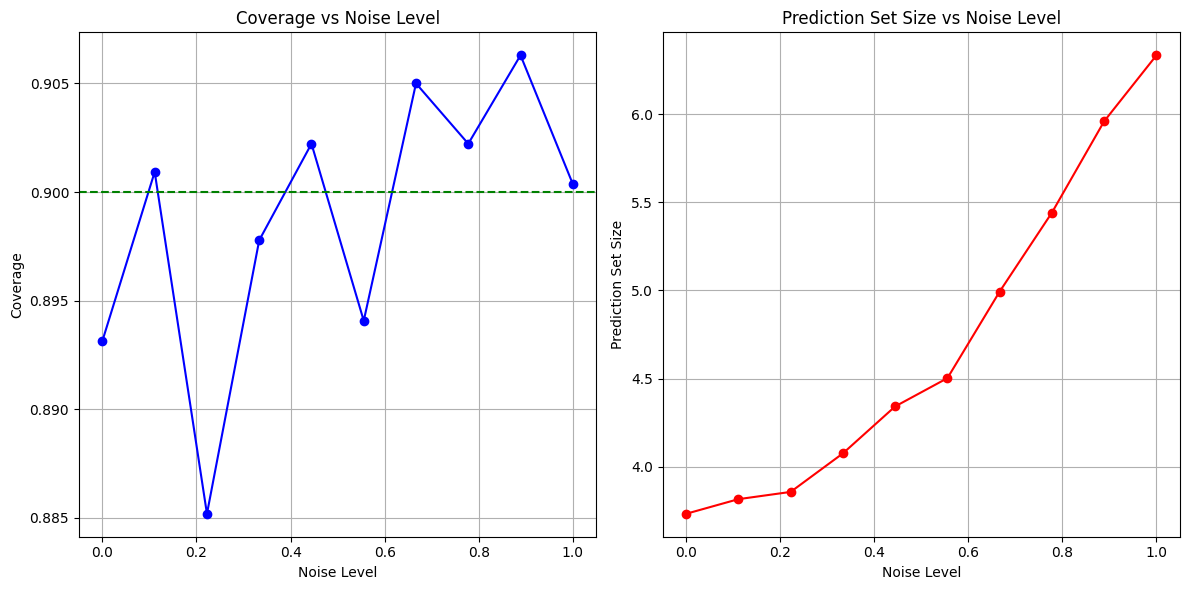

0.8987222222222222
4.705425925925926


In [ ]:
import torch.nn.functional as F
import random
np.random.seed(42)
random.seed(42)
#Add Gaussian noise

def conformal_prediction_interval(scores, alpha):
    return np.quantile(scores, 1 - alpha)

def prediction_set(prob, threshold):
    return (prob <= threshold)

# Parameters
alpha_value = 0.1
noise_levels = np.linspace(0, 1, 10)  # From no noise to high noise
coverages = []
set_sizes = []

# Loop over noise levels
for noise_level in noise_levels:
    # Add Gaussian noise to the calibration set
    X_calib_noisy = add_gaussian_noise(X_calib, mean=0, std=noise_level)

    # Get predicted probabilities for the noisy calibration set
    prob_calib_noisy = clf.predict_proba(X_calib_noisy)

    # Split the data into calibration and validation/test sets
    n = int(0.7*len(X_calib))  # Define size of calibration set
    idx = np.array([1] * n + [0] * (X_calib.shape[0] - n)) > 0
    np.random.shuffle(idx)
    cal_smx, val_smx = prob_calib_noisy[idx, :], prob_calib_noisy[~idx, :]
    cal_labels, val_labels = y_calib[idx], y_calib[~idx]

    # Diff with my code is this partition Angelopolous does, it makes sense
    # I didnt do it bc Im adding noise to the existing calibration...

    #cal_smx, val_smx = prob_calib_noisy[idx, :], prob_calib_noisy[~idx, :]
    #cal_labels, val_labels = y_calib[idx], y_calib[~idx]


    # Sorting scores and computing nonconformity scores for calibration set
    cal_pi = cal_smx.argsort(1)[:, ::-1]
    cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1)
    cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[
        range(n), cal_labels
    ]

    # Calculate qhat (non-confor threshold quantile for coverage)
    qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha_value)) / n, interpolation="higher")

    # Sort and calculate prediction sets for validation set
    val_pi = val_smx.argsort(1)[:, ::-1]
    val_srt = np.take_along_axis(val_smx, val_pi, axis=1).cumsum(axis=1)
    prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)

    # Calculate empirical coverage
    empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]), val_labels].mean()
    coverages.append(empirical_coverage)

    # Calculate the set size for noisy calibration set
    mean_set_size = prediction_sets.sum(axis=1).mean()
    set_sizes.append(mean_set_size)


plt.figure(figsize=(12, 6))

# Coverage vs Noise Level
plt.subplot(1, 2, 1)
plt.plot(noise_levels, coverages, marker='o', color='b')
plt.axhline(y=1-alpha_value, color='g', linestyle='--', label=f'1-α = {1-alpha_value}')
plt.title('Coverage vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Coverage')
plt.grid(True)

# Set Size vs Noise Level
plt.subplot(1, 2, 2)
plt.plot(noise_levels, set_sizes, marker='o', color='r')
plt.title('Prediction Set Size vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Prediction Set Size')
plt.grid(True)

plt.tight_layout()
plt.show()

print(np.mean(coverages))
print(np.mean(set_sizes))